In [25]:
#To implement any no. of hidden layers in Tensorflow.
#We will be working on MNIST dataset
#You can get the dataset from the link: https://www.kaggle.com/c/digit-recognizer/download/train.csv

#First import the basic stuff

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

#Now we will create a function to read the data  and return a normalized numpy matrix
def get_data():
    df=pd.read_csv("train.csv")
    data=df.as_matrix()
    X=data[:,1:]
    Y=data[:,0]
    mean=X.mean(axis=0) #Mean of every col
    std=X.std(axis=0) #Standard deviation of every col
    #To normalize the data we will use the formula:
    #X_normlized=(X-X_mean_along_cols)/(X_standard_dev_along_cols)
    #To ensure that we do not encounter a divide by zero exception we replace all standard deviation 0 values with 1
    np.place(std,std==0,1)
    X=(X-mean)/std
    return X,Y

X,Y=get_data()



In [26]:
#We will split the training data for cross-validation
#The last 700 samples will be for testing and the rest of the samples will be for training

split=-700
Xtrain,Ytrain=X[:split],Y[:split]
Xtest,Ytest=X[split:],Y[split:]

#We will now convert Ytrain and Ytest as indicator matrices which is similar to one hot encoding
Ytrain_ind=pd.get_dummies(Ytrain).as_matrix()
Ytest_ind=pd.get_dummies(Ytest).as_matrix()

#Lets define all the constant terms we need
lr=0.00004 # learning rate
no_of_iter=12
display_step=20

N,D=Xtrain.shape #N is the no. of samples and D is the no. of dimensions or features

#We will perform a batch gradient descent with batch size=250

batch_size=250
n_batches=int(N//batch_size) #no. of batches

K=len(set(Ytrain)) #No. of classes,here we have 10 for the digits 0 to 9
M1=Xtrain.shape[1] #M1 is now equal to the no. of dimensions i.e. 784


In [27]:
#Now coming to the hidden layers,we will have a list that holds the sizes of the hidden layers
hls=[100,300] #Hidden Layer sizes.Here we have 2 hidden layers with 100 and 300 nodes

#Lets create a  list to store the weights for each layer
Wl=[]

#We will now create a function that initializes the weights of a single layer as W and b(bias) and returns them as a list
def HiddenLayer(M1,M2):
    W=np.random.randn(M1,M2)/np.sqrt(M1)
    b=np.zeros(M2)
    return [W,b]

#Lets initialize the weights
for M2 in hls:
    Wl.append(HiddenLayer(M1,M2))
    M1=M2

#Final weight layer will be in a seperate list
FWl=HiddenLayer(M2,K)

#Create tensorflow placeholders for storing the data and the target
#It is a must to specify the data type for tensorflow placeholders

X=tf.placeholder(tf.float32,shape=(None,D),name='X')
T=tf.placeholder(tf.float32,shape=(None,K),name='T')

#Forward propagation
Xtemp=X
for l in Wl:
    W=tf.Variable(l[0].astype(np.float32))
    b=tf.Variable(l[1].astype(np.float32))
    Z=tf.nn.relu(tf.matmul(Xtemp,W)+b) #We are using the ReLu activation function
    Xtemp=Z

#Finally propagate through the final layer and get the predictions
Yish=tf.matmul(Xtemp,FWl[0].astype(np.float32))+FWl[1].astype(np.float32)

#Lets define our cost function
cost=tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=Yish,labels=T))

#Tensorflow will automatically apply our chosen Gradient Descent Optimizer to reduce the cost.
#For that lets specify our optimizer
train_op=tf.train.RMSPropOptimizer(lr,momentum=0.9).minimize(cost)

#Lets predict our outputs
predict_op=tf.argmax(Yish,1)

#We will create a list to store the costs visualize how the cost is decreasing
costs=[]

#We need to initialize all variables first
init=tf.global_variables_initializer()



Cost / err at iteration i=0, j=0: 1656.572 / 0.883
Cost / err at iteration i=0, j=20: 1149.355 / 0.329
Cost / err at iteration i=0, j=40: 659.237 / 0.206
Cost / err at iteration i=0, j=60: 396.643 / 0.143
Cost / err at iteration i=0, j=80: 290.971 / 0.113
Cost / err at iteration i=0, j=100: 245.364 / 0.100
Cost / err at iteration i=0, j=120: 215.423 / 0.093
Cost / err at iteration i=0, j=140: 195.892 / 0.084
Cost / err at iteration i=0, j=160: 184.406 / 0.089
Cost / err at iteration i=1, j=0: 181.466 / 0.087
Cost / err at iteration i=1, j=20: 170.165 / 0.081
Cost / err at iteration i=1, j=40: 160.171 / 0.074
Cost / err at iteration i=1, j=60: 153.966 / 0.074
Cost / err at iteration i=1, j=80: 143.868 / 0.067
Cost / err at iteration i=1, j=100: 141.669 / 0.061
Cost / err at iteration i=1, j=120: 132.428 / 0.057
Cost / err at iteration i=1, j=140: 129.633 / 0.056
Cost / err at iteration i=1, j=160: 127.354 / 0.054
Cost / err at iteration i=2, j=0: 126.460 / 0.056
Cost / err at iteration 

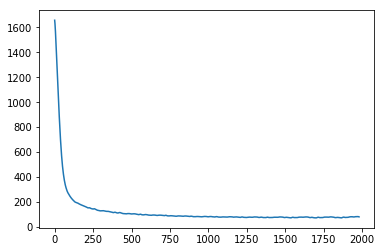

In [28]:
#We are left with defining one important function i.e. error_rate
def error_rate(p,t):
    return np.mean(p!=t)


#Now lets start the tensorflow session and perform our training and testing process
with tf.Session() as sess:
    sess.run(init) #To initialize all variables
    
    for i in range(no_of_iter):
        
        for j in range(n_batches):
            
            #Get the training batches
            Xbatch=Xtrain[j*batch_size:(j+1)*batch_size]
            Ybatch=Ytrain_ind[j*batch_size:(j+1)*batch_size]
            
            #Lets call the training process
            sess.run(train_op,feed_dict={X:Xbatch,T:Ybatch})
            
            #Lets get the cost , prediction and error rate:
            test_cost=sess.run(cost,feed_dict={X:Xtest,T:Ytest_ind})
            prediction=sess.run(predict_op,feed_dict={X:Xtest})
            
            #Every 20 steps we want to see the status of our training
            if(j%display_step==0):
                err=error_rate(prediction,Ytest)
                print ("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
            
            #Lets append our test cost to the list of costs we have create
            costs.append(test_cost)

#Finally after the training is over we want to see the plot of our cost
plt.plot(costs)
plt.show()
                
                